# Итоговый проект по курсу от Megafon

## Часть 1. Исследование и предварительная подготовка данных

### Легенда
У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.


### Данные
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
### Итого, в качестве входных данных будут представлены:
data_train.csv: id, vas_id, buy_time, target
features.csv.zip: id, <feature_list> 

### И тестовый набор:
data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.
### Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

## Установка дополнительных библиотек

In [95]:
# !pip install luigi
# !pip install dask
# !pip install pandas

### Импорт библиотек и объявление утилитарных функций

In [96]:
from datetime import datetime
from matplotlib import pyplot as plt
import os
import numpy as np

def convert_buy_time_to_datetime(dataframe):
    dataframe['buy_time'] = dataframe['buy_time'].apply(lambda timestamp: datetime.fromtimestamp(timestamp))
    return dataframe

def filter_buy_time_by_date(dataframe, date):
    return dataframe[dataframe['buy_time'] != date]

def build_histogram_by_column(dataframe_column, label, title, filename, size=(20, 10), shouldSave=True):
    plt.figure(figsize=size)
    dataframe_column.value_counts().plot(kind='bar', label=label)
    plt.legend()
    plt.title(title)
    if shouldSave and len(filename) != 0:
        output_file_path = os.path.join('plots', filename)
        plt.savefig(output_file_path);

def show_target_time_distribution(dataframe, filename, y_max, size=(50, 20), shouldSave=True):
    plt.figure(figsize=size)
    dataframe.groupby(['buy_time'])['target'].apply(lambda x: sum(x) / len(x)).plot()
    plt.xticks(dataframe['buy_time'].unique())
    plt.yticks(np.arange(0, y_max, 0.05))
    plt.grid()
    if shouldSave and filename:
        output_file_path = os.path.join('plots', filename)
        plt.savefig(output_file_path);
    plt.show()

In [97]:
# Константы путей к данным

DATA_TEST_PATH = './data/data_test.csv'
DATA_TRAIN_PATH = './data/data_train.csv'
FEATURES_PATH = './data/features.csv'

TRUNCATED_FEATURES_PATH = './data/truncated_features.csv'
DATA_TRAIN_WITH_FEATURES_PATH = './data/data_train_with_features.csv'
DATA_TEST_WITH_FEATURES_PATH = './data/data_test_with_features.csv'

## Загружаем данные

In [98]:
import pandas as pd
import dask.dataframe as dd

df_test = pd.read_csv(DATA_TEST_PATH)
df_train = pd.read_csv(DATA_TRAIN_PATH)
features = dd.read_csv(FEATURES_PATH, sep ='\t')

## Исследуем данные


In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [100]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


### Посмотрим на количество классов в target

In [101]:
df_train['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

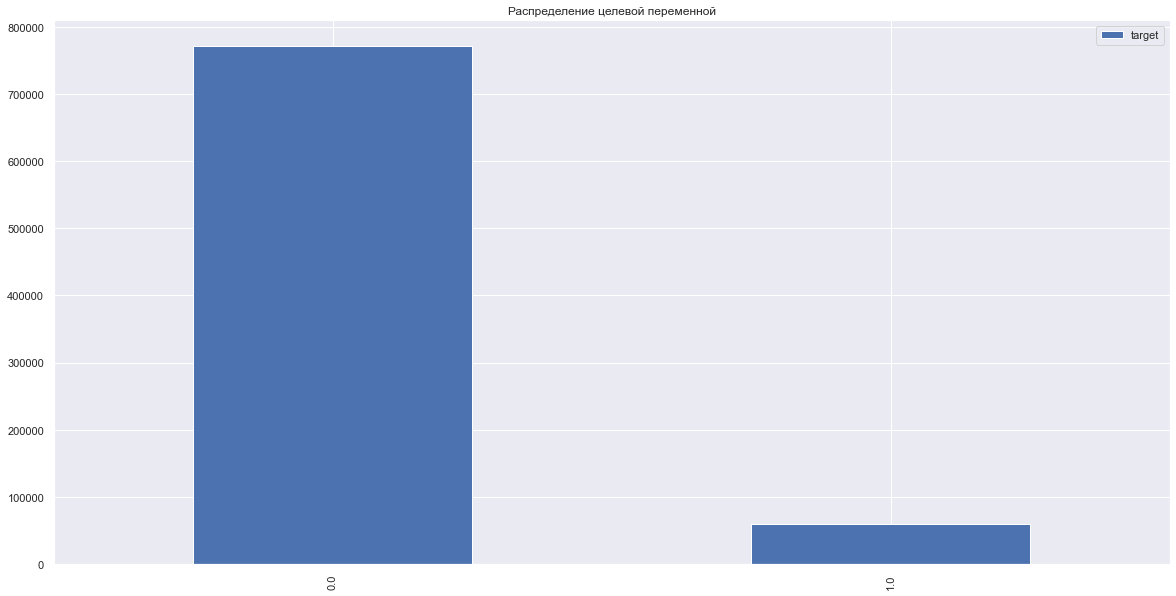

In [102]:
build_histogram_by_column(df_train['target'], 'target', 'Распределение целевой переменной', 'target_before_processing')

Наблюдаем:
 - классов 2, значит будем решать задачу бинарной классификации
 - явный дисбаланс классов (возможно в ходе работы придется сделать дополнительное семплирование)

### Посмотрим на сами данные

In [103]:
df_train.head(5)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


buy_time содержит timestamp и требует приведения к datetime, сделаем это:

In [104]:
df_train = convert_buy_time_to_datetime(df_train)
df_test = convert_buy_time_to_datetime(df_test)
df_train.head(5)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,2018-09-17,0.0
1,1,1454121,4.0,2018-07-16,0.0
2,2,2458816,1.0,2018-08-13,0.0
3,3,3535012,5.0,2018-09-03,0.0
4,4,1693214,1.0,2018-09-03,0.0


In [119]:
df_test.head(5)

,id,vas_id,buy_time
0,3130519,2.0,2019-01-21
1,2000860,4.0,2019-01-21
2,1099444,2.0,2019-01-07
3,1343255,5.0,2019-01-14
4,1277040,2.0,2019-01-07


In [105]:
from matplotlib import pyplot as plt

Посмотрим, как распределена целевая переменная во времени. Построим зависимость на графике

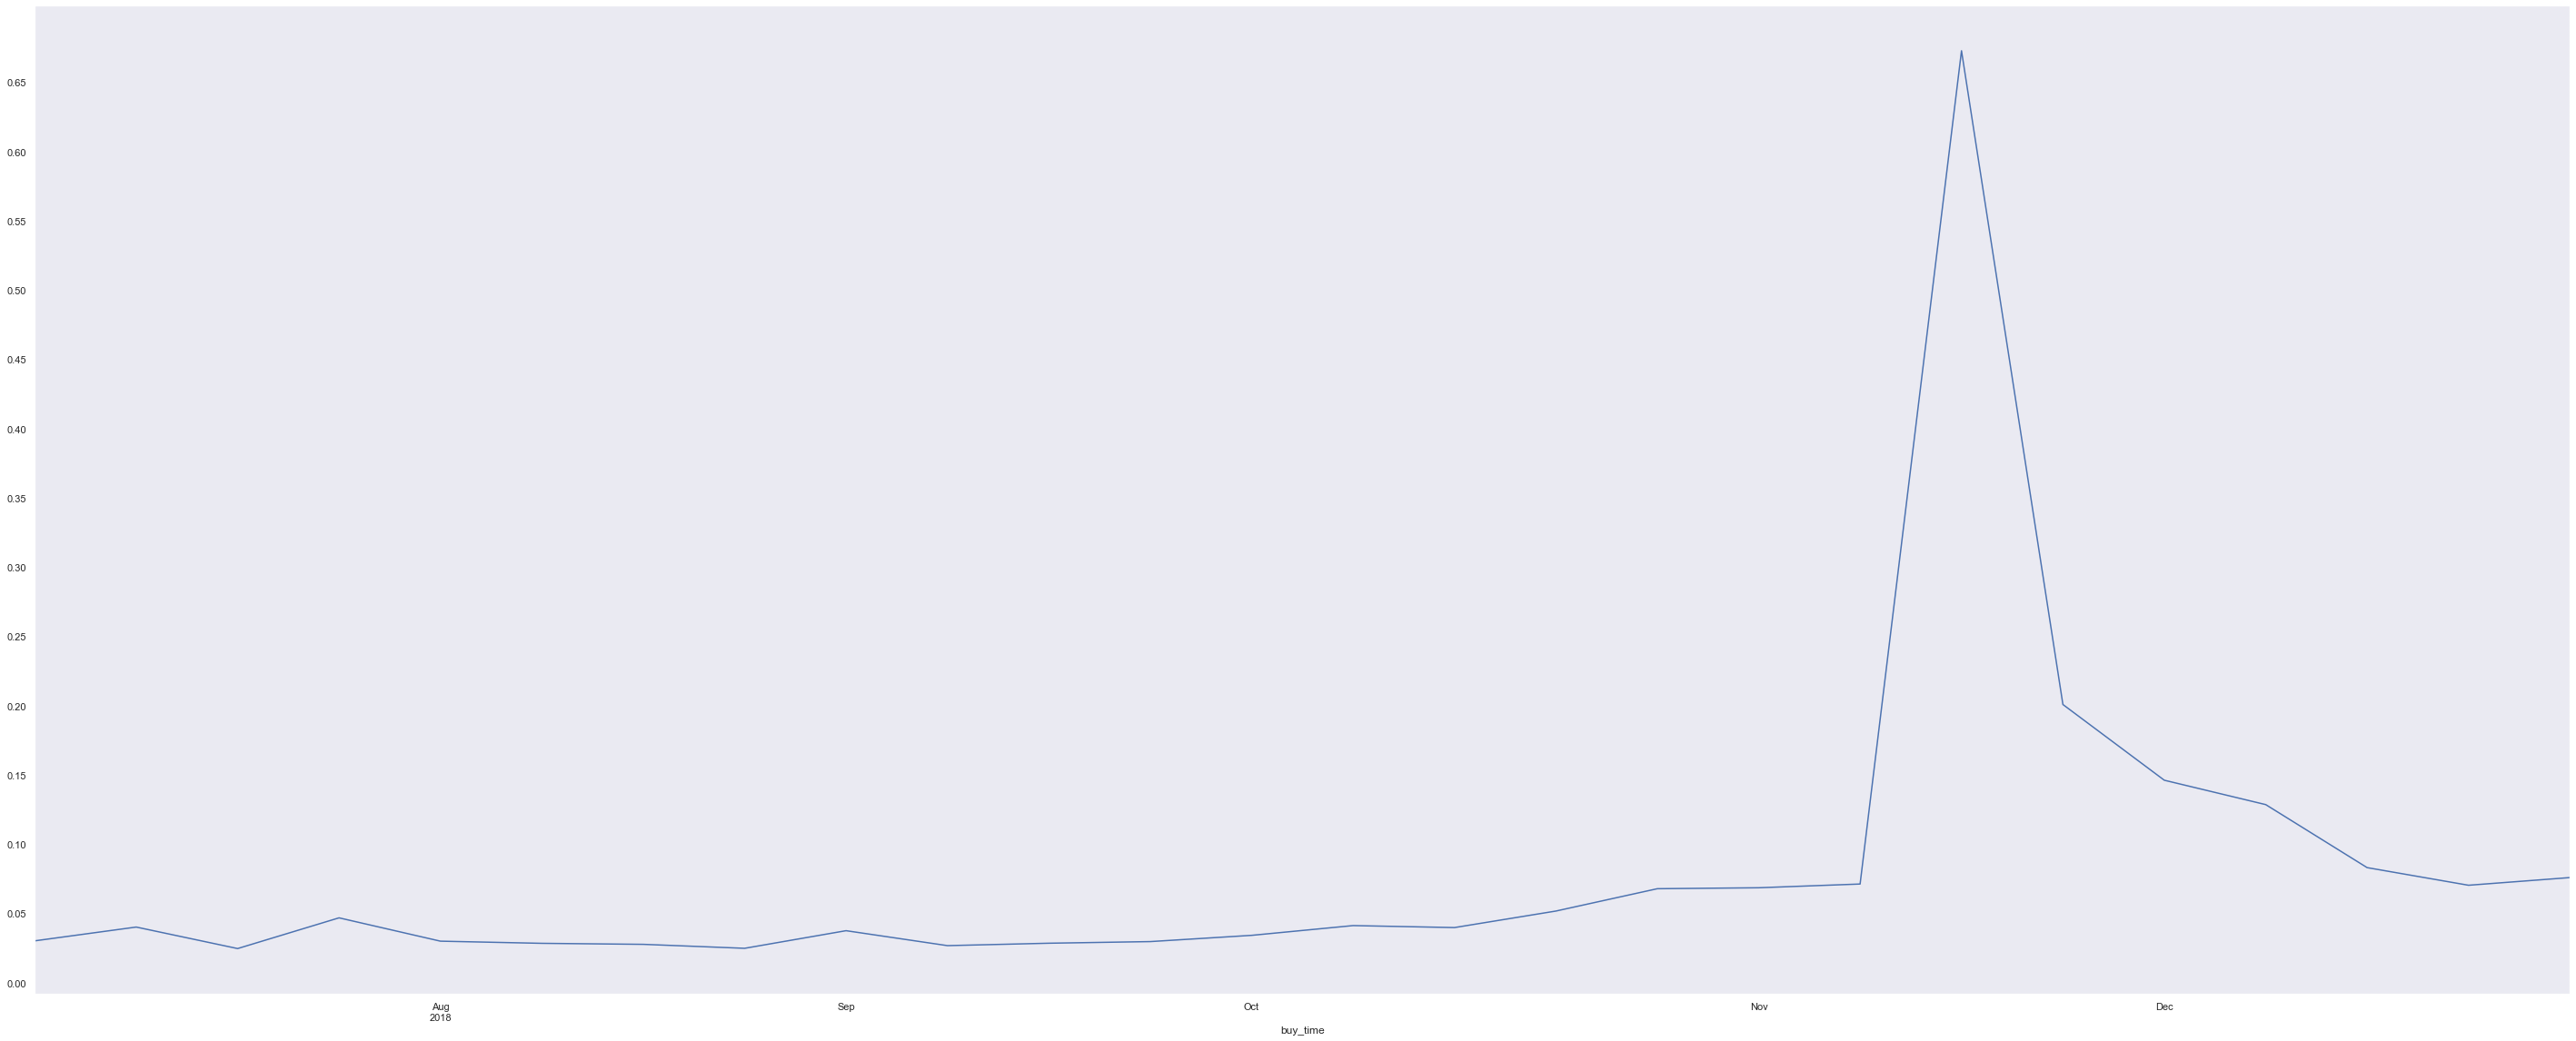

In [106]:
show_target_time_distribution(df_train, 'target_distribution.png', y_max=0.7)

Судя по тренировочной выборке всплеск продаж пришелся на 19 ноября. Акция явно сработала, но учет этих данных может повредить модели, поэтому просто вырежем их.

In [107]:
df_train = filter_buy_time_by_date(df_train, '2018-11-19')
df_test = filter_buy_time_by_date(df_test, '2018-11-19')
features = filter_buy_time_by_date(features, '2018-11-19')

In [108]:
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['Unnamed: 0'])

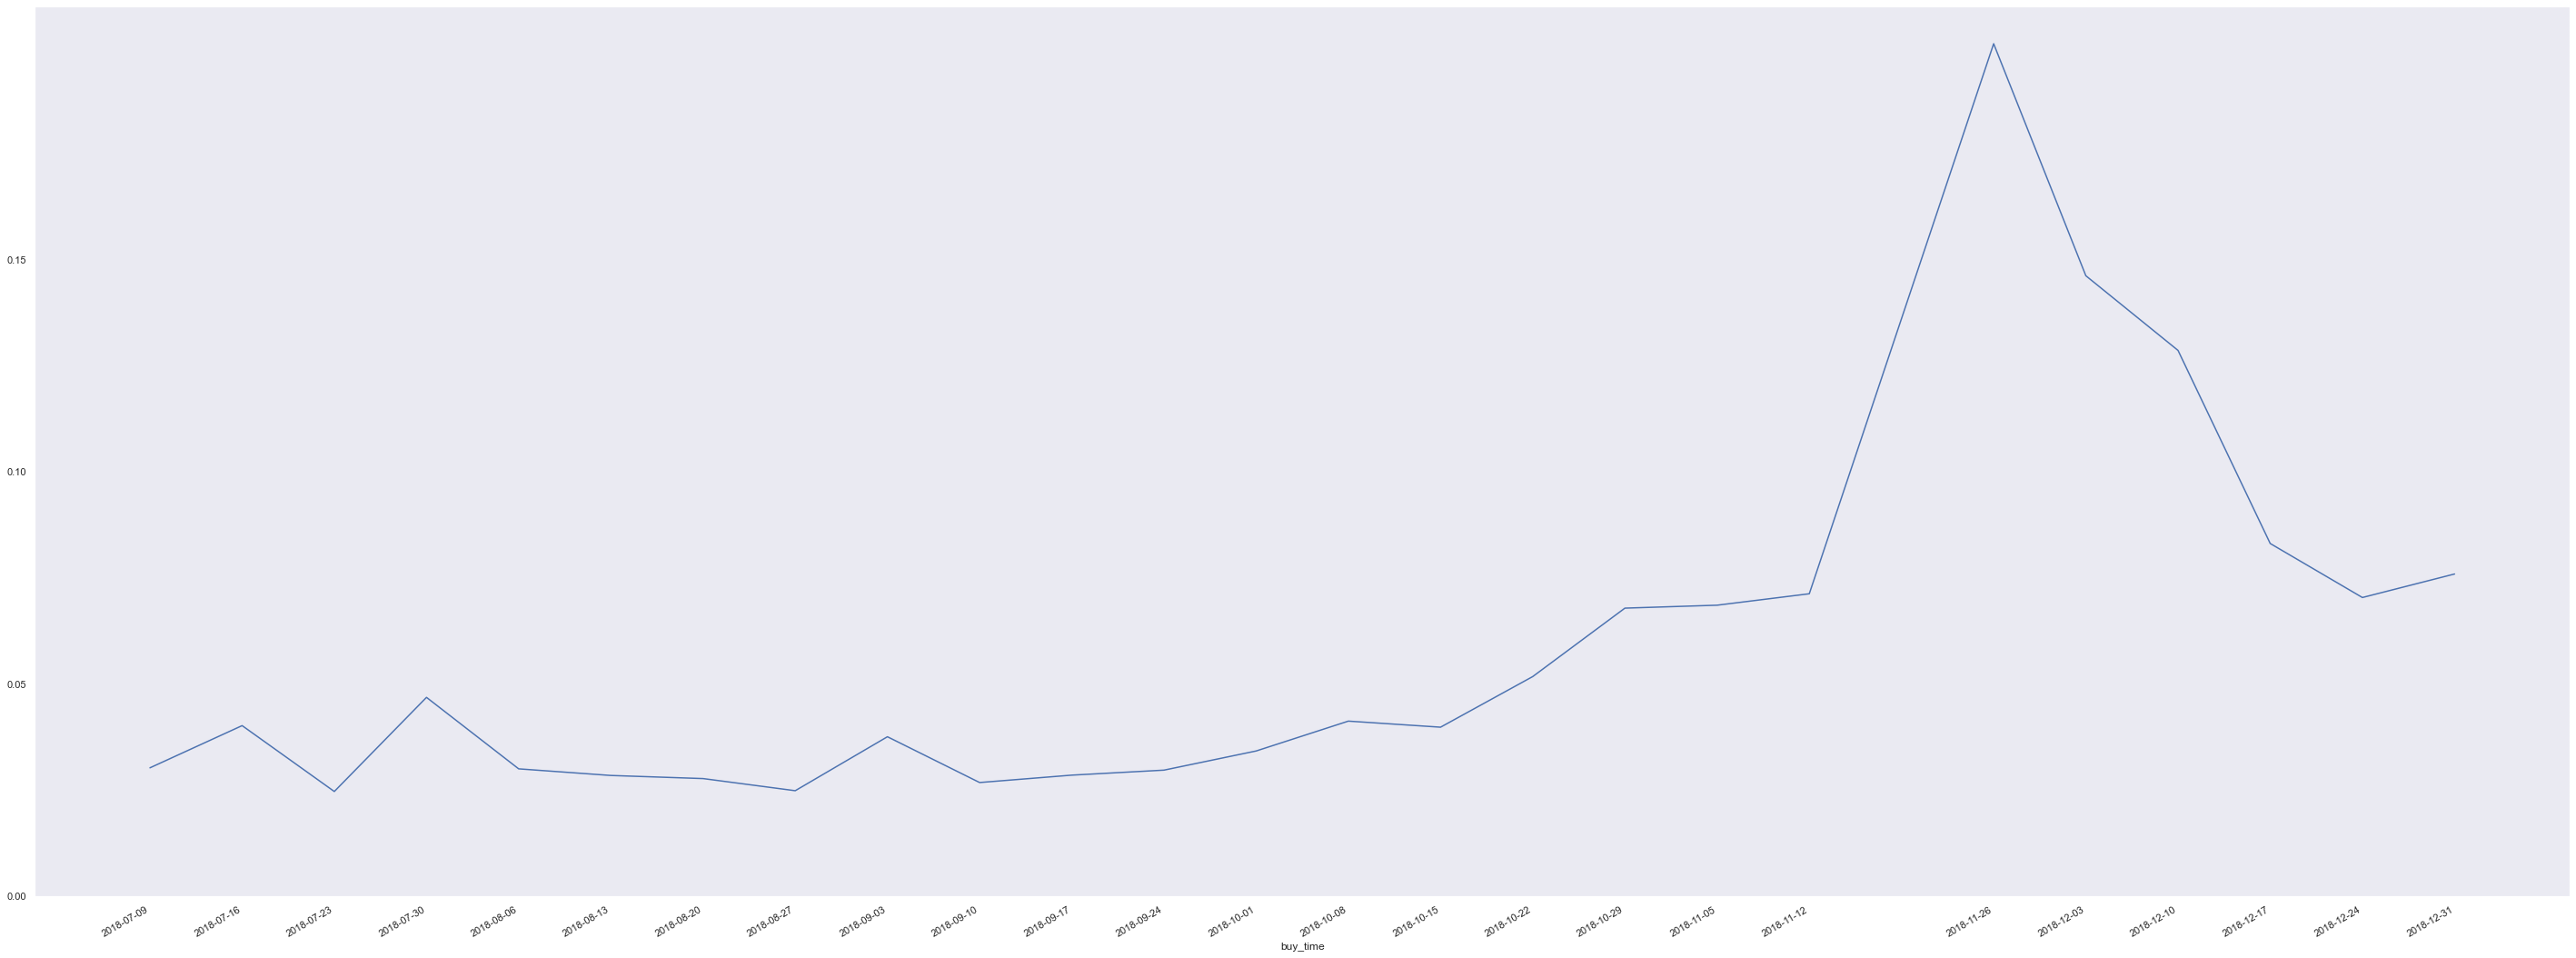

In [109]:
show_target_time_distribution(df_train, 'target_distribution_after_cut_off_flash.png', y_max=0.2)

### Проверим датасет на дублирующиеся id

In [110]:
df_train.duplicated(subset=['id']).value_counts()

False    795253
True      13485
dtype: int64

Часть id дублируется (если это id пользователей, то вероятно у них не по одной Sim-карте)

===

In [111]:
# features.head(5)

### Просмотрим, сколько всего данных в датасете features

In [112]:
# len(features.index)
# 4 512 528

обработка сильно затянется, поэтому попробуем усечь этот датасет и оставить только интересующие нас данные

In [113]:
def truncate_features(df_features, train, test):
    user_ids = np.unique(train['id'].append(test['id']))
    # Оставим id пользователей, из train и test
    df_features = df_features[df_features['id'].isin(user_ids)]

    # Удаляем столбец Unnamed: 0
    if 'Unnamed: 0' in df_features:
        df_features = df_features.drop(columns='Unnamed: 0')
    df_features = df_features.compute()

    # Удаляем признаки с единственным значением
    df_nunique = df_features.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique == 1].index.tolist()
    df_features = df_features.drop(columns = const)
    return df_features

In [114]:
df_features = truncate_features(features, df_train, df_test)
df_features

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
22,2075318,1533502800,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174,3513869,1548018000,82.370029,-123.429112,155.939214,-88.526798,150.521754,-109.63179,-16.08618,-65.076097,...,-928.373846,-570.770792,-23.996269,-37.630448,-271.747724,-22.832889,-0.694428,-12.175933,-0.45614,0.0
2183,3516552,1547413200,-96.799971,-116.519112,-110.740786,-169.126798,-116.158246,-190.23179,-16.08618,226.583903,...,-975.373846,-613.770792,-25.996269,-37.630448,-5.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
2187,3517434,1548018000,-96.799971,-284.349112,-100.740786,-274.796798,-106.158246,-295.90179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2195,3519714,1546808400,167.280029,110.140888,153.339214,57.533202,147.921754,36.42821,-2.00618,-50.996097,...,-977.373846,-613.770792,-14.996269,7.369552,-180.747724,-19.832889,0.305572,-12.175933,-0.45614,0.0


Сохраним усеченный датасет в отдельный файл

In [115]:
df_features.to_csv(TRUNCATED_FEATURES_PATH)

## Приджоиним features к train и test

In [116]:
df_train_with_features = df_train.merge(df_features, on='id', how = 'left')
df_test_with_features = df_test.merge(df_features, on='id', how = 'left')

## Экспортируем данные

In [117]:
df_train_with_features.to_csv(DATA_TRAIN_WITH_FEATURES_PATH)
df_test_with_features.to_csv(DATA_TEST_WITH_FEATURES_PATH)

In [118]:
df_train_with_features

,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,2018-09-17,0.0,1541970000,-31.559971,327.360888,-45.500786,274.753202,-50.918246,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,2018-07-16,0.0,1531083600,547.270029,238.430888,533.329214,274.803202,527.911754,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,2018-08-13,0.0,1543179600,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,2018-09-03,0.0,1533502800,54.880029,12.970888,54.079214,-9.116798,48.661754,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,2018-09-03,0.0,1543179600,45.160029,295.240888,64.679214,344.283202,59.261754,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836337,3812226,2.0,2018-12-31,0.0,1532898000,29.750029,6.200888,24.279214,-37.936798,18.861754,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
836338,2480469,2.0,2018-12-31,0.0,1532293200,-89.179971,-56.499112,-103.120786,-109.106798,-108.538246,...,-66.373846,-321.770792,-25.996269,62.369552,1167.252276,41.167111,-0.694428,54.824067,-0.45614,0.0
836339,158236,2.0,2018-12-31,0.0,1538946000,-96.799971,62.140888,-110.740786,9.533202,-116.158246,...,-683.373846,-470.770792,-25.996269,-37.630448,99.252276,178.167111,-0.694428,191.824067,-0.45614,0.0
836340,1825525,2.0,2018-12-31,0.0,1533502800,-96.799971,-81.919112,-110.740786,-128.596798,-116.158246,...,1018.626154,1367.229208,-24.996269,-35.630448,-237.747724,-21.832889,-0.694428,-8.175933,-0.45614,1.0
